In [1]:
!pip install pydot -q

## Imports

In [2]:
import os
import time
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Data Preprocessing
from sklearn.model_selection import train_test_split

# Model Training
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.utils import plot_model

# TF logging
tf.get_logger().setLevel('ERROR')  # Show only errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  

2025-04-25 12:49:56.265906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745585396.559484      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745585396.645522      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Model Code

In [3]:
def base_network(input_shape=(160, 160, 1)):
    inputs = layers.Input(shape=input_shape, name="base_input")
    x = layers.Conv2D(32, (7, 7), strides=2, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    x = layers.Conv2D(64, (3, 3), strides=1, activation='relu', padding='same')(x)
    attention1 = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = layers.Multiply()([x, attention1])
    x = layers.Conv2D(128, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)
    attention2 = layers.Conv2D(1, (1, 1), activation='sigmoid', padding='same')(x)
    x = layers.Multiply()([x, attention2])
    x = layers.Conv2D(256, (3, 3), strides=2, activation='relu', padding='same')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128)(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1), output_shape=(128,))(x)
    return models.Model(inputs, outputs, name="base_network")

def KeyNet(input_shape=(160, 160, 1)):
    # Create the base network
    base_model = base_network(input_shape)

    # Inputs for triplets
    input_anchor = layers.Input(shape=input_shape, name="anchor")
    input_positive = layers.Input(shape=input_shape, name="positive")
    input_negative = layers.Input(shape=input_shape, name="negative")

    # Compute embeddings for each input
    anchor_embedding = base_model(input_anchor)
    positive_embedding = base_model(input_positive)
    negative_embedding = base_model(input_negative)

    # Concatenate embeddings for triplet loss
    outputs = layers.Concatenate(axis=1)([anchor_embedding, positive_embedding, negative_embedding])

    return models.Model([input_anchor, input_positive, input_negative], outputs)

def triplet_loss(y_true, y_pred, margin=0.5):
    # margin (𝛼=0.5 or 𝛼=1.0)
    anchor, positive, negative = tf.split(y_pred, num_or_size_splits=3, axis=1)
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=1)
    return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))

def KeyNet_infer(input_shape=(160, 160, 1)):
    # Use only the base network for inference
    return base_network(input_shape)

## Diagram Code

2025-04-25 12:50:13.904616: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


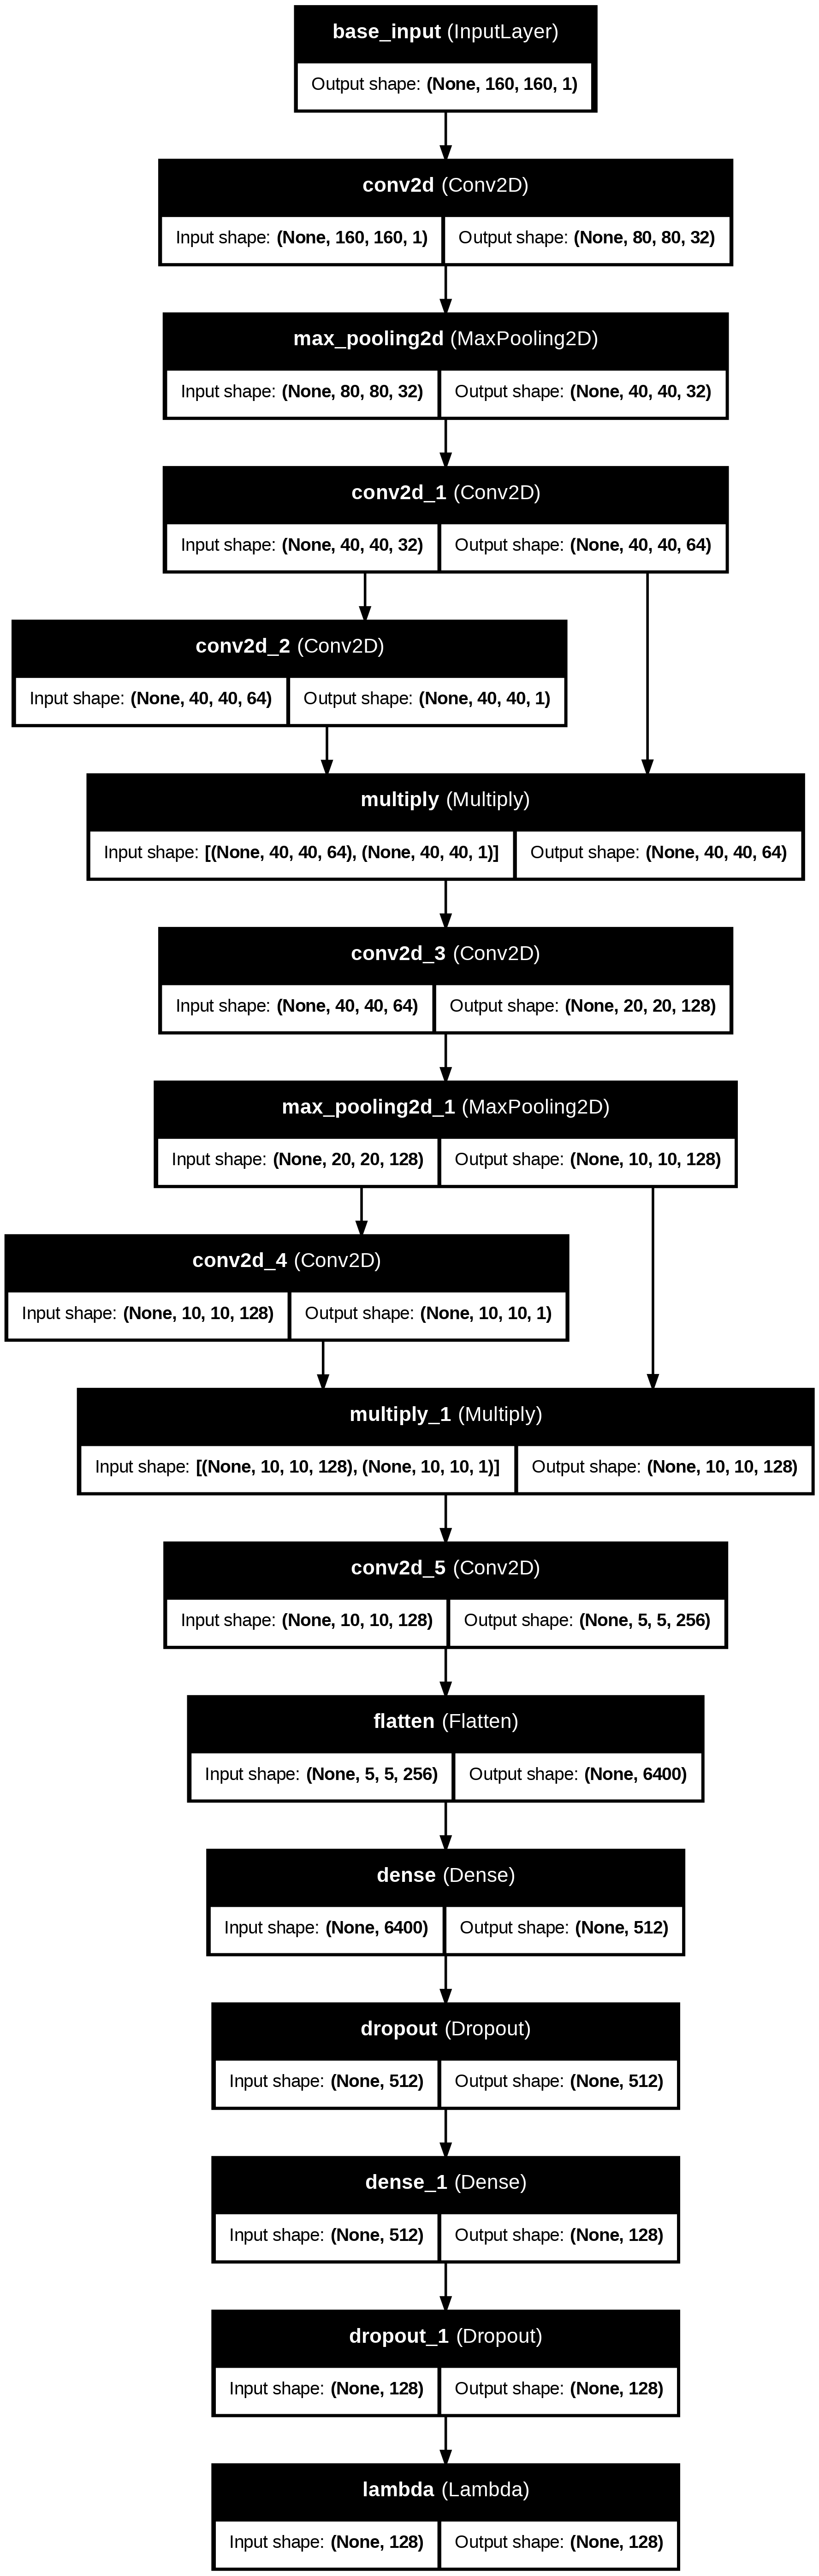

In [4]:
# For the base network
base_model = base_network()
plot_model(base_model, to_file='base_model.png', show_shapes=True, show_layer_names=True)

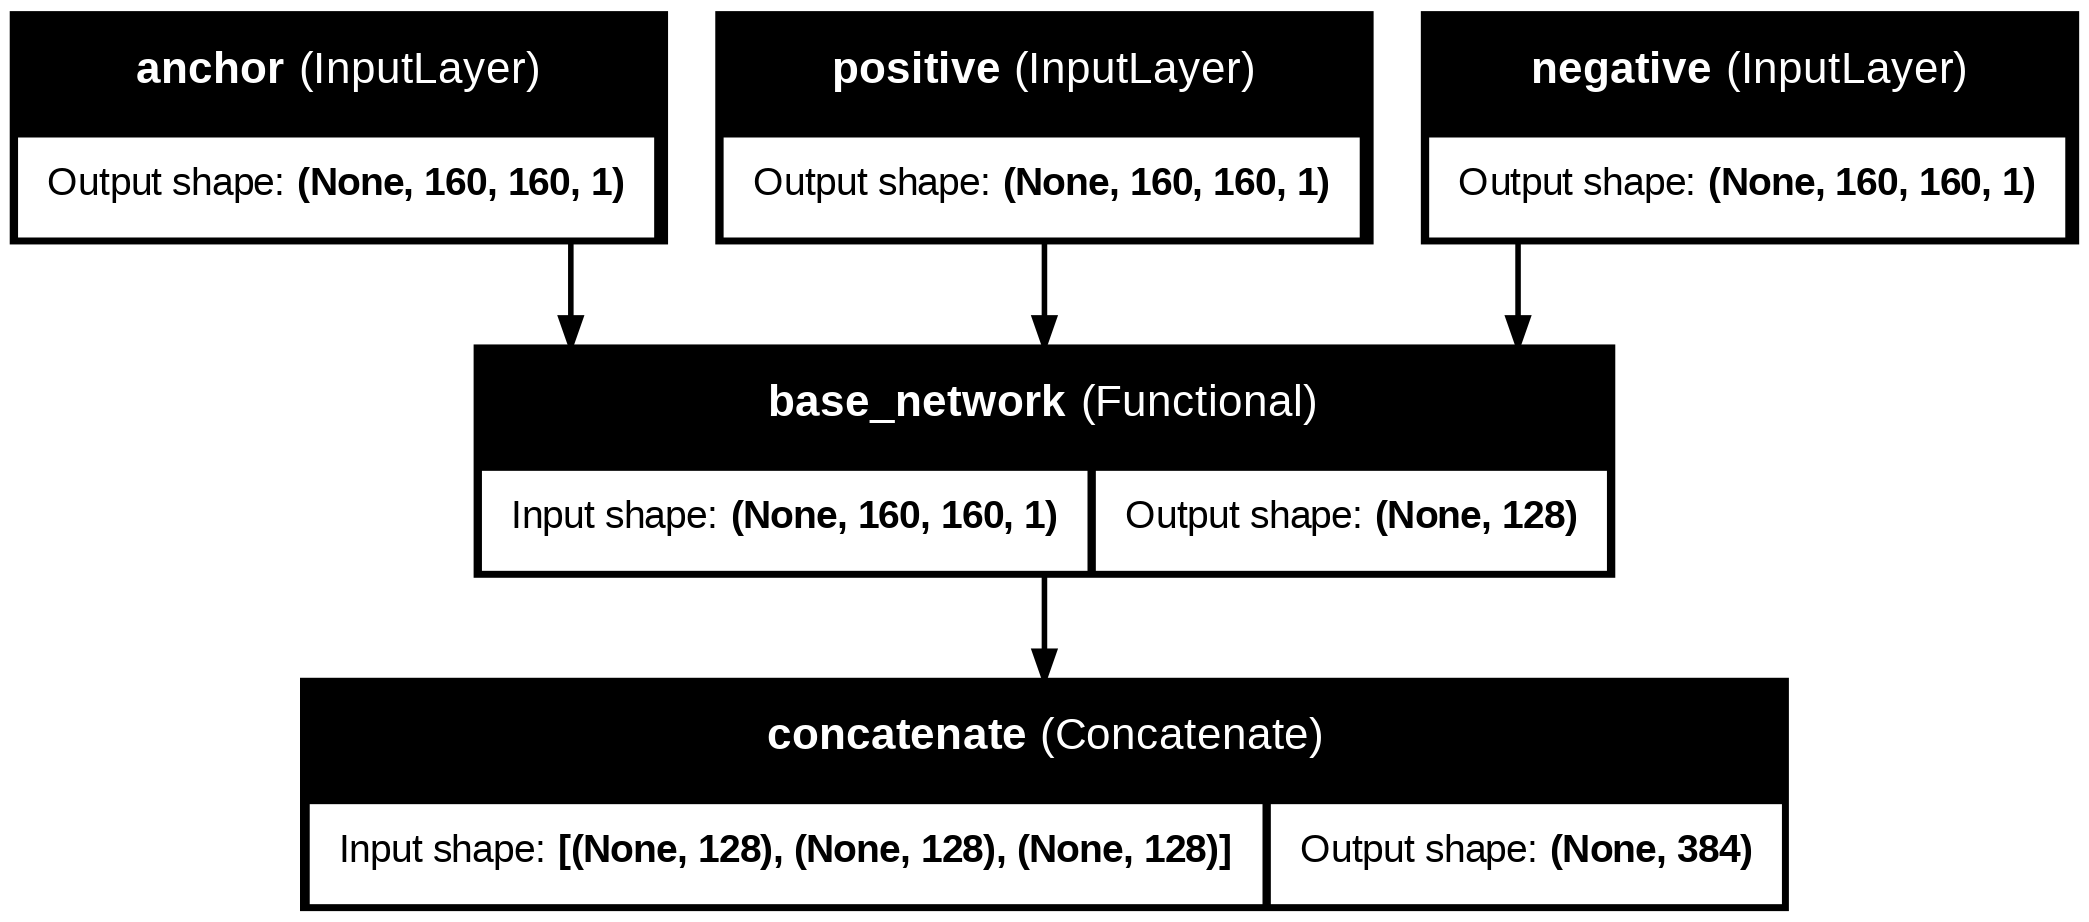

In [5]:

# For the full KeyNet model
keynet_model = KeyNet()
plot_model(keynet_model, to_file='keynet_model.png', show_shapes=True, show_layer_names=True)

In [6]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 12.7 MB/s eta 0:00:0000:010:01


/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


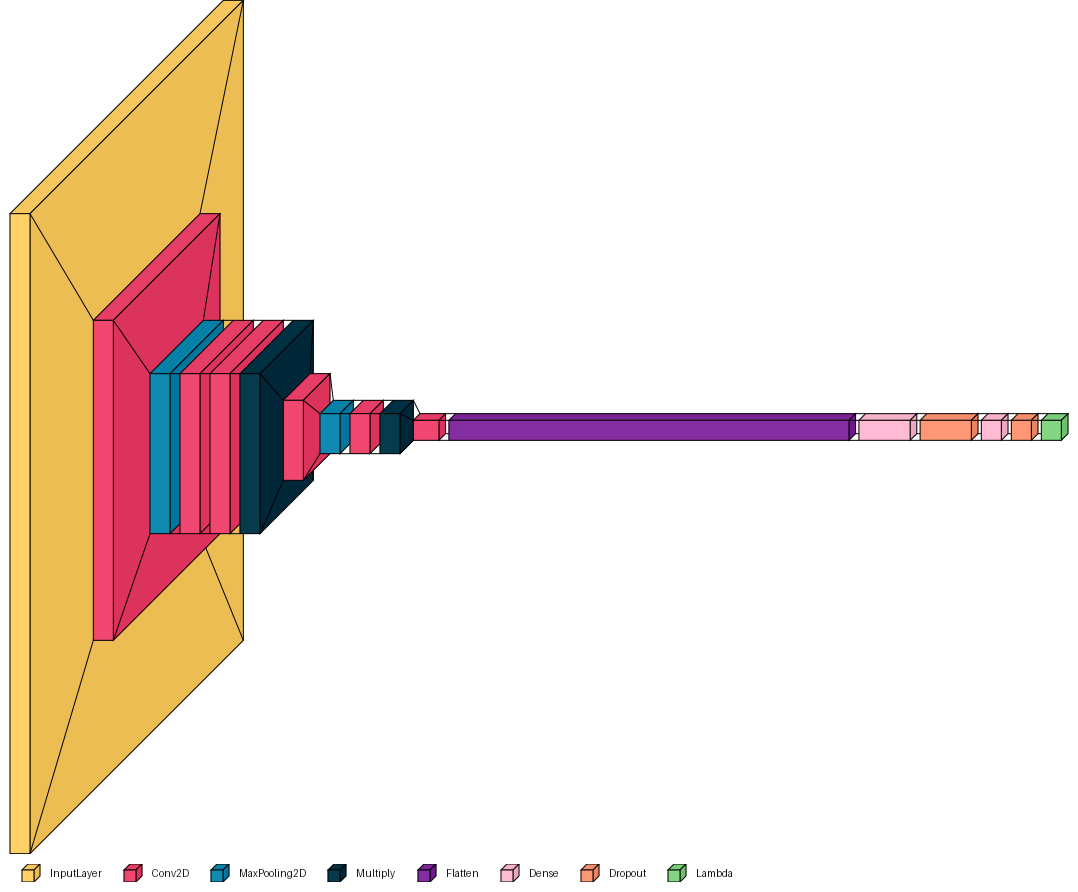

In [7]:
import visualkeras
from tensorflow.keras.models import Model

# Visualize the base network
base_model = base_network()
visualkeras.layered_view(base_model, to_file='base_model_visualkeras.png', legend=True)

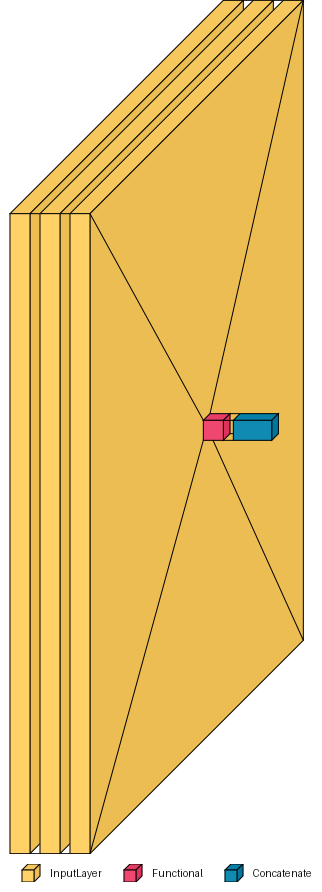

In [8]:

# Visualize the full KeyNet model
keynet_model = KeyNet()
visualkeras.layered_view(keynet_model, to_file='keynet_model_visualkeras.png', legend=True)